In [82]:
import tensorflow as tf
import tensorflow.python.keras as keras
from tensorflow.python.keras.layers import Conv2D, GaussianNoise
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [2]:
def _build_SRM_kernel():
    q = [4.0, 12.0, 2.0]
    filter1 = [[0, 0, 0, 0, 0],
               [0, -1, 2, -1, 0],
               [0, 2, -4, 2, 0],
               [0, -1, 2, -1, 0],
               [0, 0, 0, 0, 0]]
    filter2 = [[-1, 2, -2, 2, -1],
               [2, -6, 8, -6, 2],
               [-2, 8, -12, 8, -2],
               [2, -6, 8, -6, 2],
               [-1, 2, -2, 2, -1]]
    filter3 = [[0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0],
               [0, 1, -2, 1, 0],
               [0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0]]
    filter1 = np.asarray(filter1, dtype=float) / q[0]
    filter2 = np.asarray(filter2, dtype=float) / q[1]
    filter3 = np.asarray(filter3, dtype=float) / q[2]
    filters = [[filter1, filter1, filter1], [filter2, filter2, filter2], [filter3, filter3, filter3]]
    filters = np.einsum('klij->ijlk', filters)
    filters = filters.flatten()
    initializer_srm = tf.constant_initializer(filters)

    return initializer_srm

In [159]:
def gaussian_blur(img, kernel_size=11, sigma=5):
    def gauss_kernel(channels, kernel_size, sigma):
        ax = tf.range(-kernel_size // 2 + 1.0, kernel_size // 2 + 1.0)
        xx, yy = tf.meshgrid(ax, ax)
        kernel = tf.exp(-(xx ** 2 + yy ** 2) / (2.0 * sigma ** 2))
        kernel = kernel / tf.reduce_sum(kernel)
        kernel = tf.tile(kernel[..., tf.newaxis], [1, 1, channels])
        return kernel

    gaussian_kernel = gauss_kernel(tf.shape(img)[-1], kernel_size, sigma)
    gaussian_kernel = gaussian_kernel[..., tf.newaxis]
    img = tf.nn.depthwise_conv2d([img], gaussian_kernel, [1, 1, 1, 1],
                                  padding='SAME', data_format='NHWC')
    return img

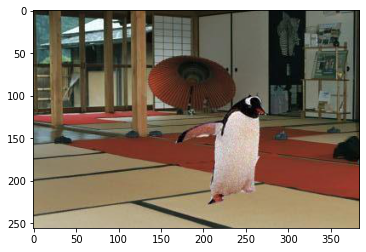

In [58]:
img = plt.imread("./img_test/10.jpg")
img = img.astype('float32') / 255.
plt.imshow(img)

In [156]:
img.shape

(256, 384, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


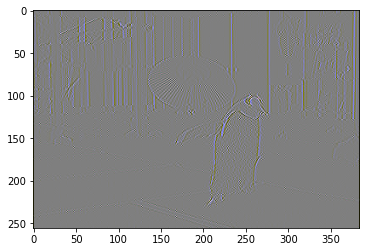

In [59]:
model = keras.Sequential()
model.add(Conv2D(3, [5, 5], trainable=False, kernel_initializer=_build_SRM_kernel(),
                                activation=None, padding='same', strides=1,
                                bias_initializer=tf.constant_initializer(0.5)))
srm = model.predict(np.array([img]))[0,...]
plt.imshow(srm)

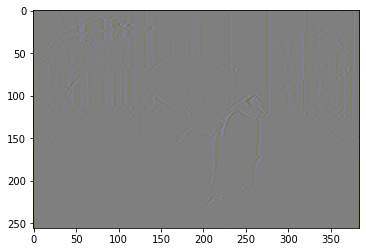

In [109]:
blurred = gaussian_blur(img,kernel_size=3, sigma=5)
noise = model.predict(np.array([blurred]))[0,...]
plt.imshow(noise)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


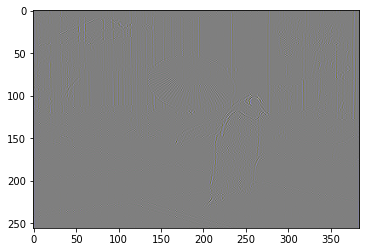

In [110]:
final = (srm-noise)/2+0.5
plt.imsave()

In [74]:
mask = plt.imread("./img_test/5_gt.png")
mask = np.sum(mask, -1)/3
distribTampsrm, distribTampfinal = [], []
n, m = mask.shape
for i in range(n):
    for j in range(m):
        if mask[i, j] == 1:
            distribTampsrm.append(srm[i, j])
            distribTampfinal.append(final[i, j])

In [75]:
distribTampsrmR = [elt[0] for elt in distribTampsrm]
distribTampsrmG = [elt[1] for elt in distribTampsrm]
distribTampsrmB = [elt[2] for elt in distribTampsrm]
sigma_srm = np.mean([np.std(distribTampsrmR), np.std(distribTampsrmG), np.std(distribTampsrmB)])

distribTampfinalR = [elt[0] for elt in distribTampfinal]
distribTampfinalG = [elt[1] for elt in distribTampfinal]
distribTampfinalB = [elt[2] for elt in distribTampfinal]
sigma_final =np.mean([np.std(distribTampfinalR), np.std(distribTampfinalG), np.std(distribTampfinalB)])

In [76]:
print(sigma_srm-sigma_final)

0.1451749


In [85]:
n, m = mask.shape
delta = []
sig, si = [], []
for size in range(1, 12, 2):
    for sigma in range(1, 10):
        srm = model.predict(np.array([img]))[0,...]
        blurred = gaussian_blur(img, size, sigma)
        noise = model.predict(np.array([blurred]))[0,...]
        final = (srm-noise)/2+0.5
        
        distribTampsrm, distribTampfinal = [], []
        for i in range(n):
            for j in range(m):
                if mask[i, j] == 1:
                    distribTampsrm.append(srm[i, j])
                    distribTampfinal.append(final[i, j])
        distribTampsrmR = [elt[0] for elt in distribTampsrm]
        distribTampsrmG = [elt[1] for elt in distribTampsrm]
        distribTampsrmB = [elt[2] for elt in distribTampsrm]
        
        sigma_srm = np.mean([np.std(distribTampsrmR), np.std(distribTampsrmG), np.std(distribTampsrmB)])

        distribTampfinalR = [elt[0] for elt in distribTampfinal]
        distribTampfinalG = [elt[1] for elt in distribTampfinal]
        distribTampfinalB = [elt[2] for elt in distribTampfinal]
        
        sigma_final =np.mean([np.std(distribTampfinalR), np.std(distribTampfinalG), np.std(distribTampfinalB)])
        delta.append(np.abs(sigma_srm-sigma_final))
        sig.append(sigma)
        si.append(size)

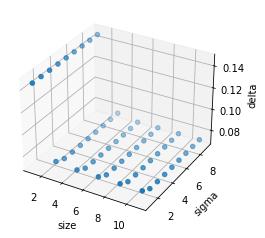

In [90]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(si, sig, delta);
ax.set_xlabel('size')
ax.set_ylabel('sigma')
ax.set_zlabel('delta');

(array([3.12816990e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.12817363e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.12817176e-03, 6.25634353e-03, 3.12817176e-03,
        3.12817176e-03, 3.12816990e-03, 0.00000000e+00, 3.12817176e-03,
        9.38451390e-03, 3.12817153e-03, 1.56408565e-02, 3.44098868e-02,
        3.12817130e-02, 4.69225765e-02, 9.38451250e-02, 1.43895901e-01,
        2.53381838e-01, 4.56713078e-01, 9.38451529e-01, 1.68608458e+00,
        4.59528159e+00, 6.95392997e+00, 2.17407808e+00, 1.10111581e+00,
        5.38045864e-01, 3.50355029e-01, 1.75177723e-01, 1.06357777e-01,
        7.50760777e-02, 2.81535626e-02, 4.69225486e-02, 3.12817363e-02,
        1.25126796e-02, 9.38450971e-03, 3.12816990e-03, 3.12817735e-03,
        6.25633981e-03, 9.38450971e-03]),
 array([-1.1617646 , -1.1116666 , -1.0615685 , -1.0114706 , -0.9613725 ,
        -0.91127443, 

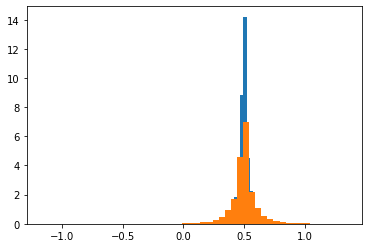

In [96]:
plt.hist(distribTampfinalR, bins=50, density=True)
plt.hist(distribTampsrmR, bins=50, density=True)